In [1]:
import numpy as np

In [2]:
# X input from 0 to 15
x = np.arange(0, 16, 1, dtype=np.float32)

# True Y values
Y_mean = np.array([-6, -5, -4, -3, -5, -4, -3, -2, -4, -3, -2, -1, -3, -2, -1, 0], dtype=np.float32)
Y_std = np.array([1.2, 1, 0.8, 0.6, 1, 0.8, 0.6, 0.4, 0.8, 0.6, 0.4, 0.2, 0.6, 0.4, 0.2, 0], dtype=np.float32)

In [3]:
def generate_batch(batch_size):
    indices = np.random.choice(len(x), batch_size)
    # sample from the true distribution Y_mean[indices], Y_std[indices]
    # return x[indices], np.random.normal(Y_mean[indices], Y_std[indices])
    return x[indices], Y_mean[indices], Y_std[indices]

def state_encoder(state):
    # one hot encoding
    state = int(state)
    state_onehot = np.zeros(len(x), dtype=np.float32)
    state_onehot[state] = 1
    return state_onehot

def state_decoder(state_onehot):
    return np.argmax(state_onehot)

In [4]:
# from pytagi.nn import Linear, OutputUpdater, ReLU, Sequential, EvenExp

# tagi_net = Sequential(
#                     Linear(1, 128),
#                     ReLU(),
#                     Linear(128, 128),
#                     ReLU(),
#                     Linear(128, 1 * 2),
#                     EvenExp()
#                     )


# samples_num = 1000
# X_samples, Y_samples = generate_batch(samples_num)
# batch_size = 10

# for epoch in range(50):
#     # randomly devide the samples into batches
#     indices = np.random.permutation(samples_num)
#     for i in range(int(samples_num/batch_size)):
#         x_batch = X_samples[indices[i*batch_size:(i+1)*batch_size]]
#         y_batch = Y_samples[indices[i*batch_size:(i+1)*batch_size]]

#         y_batch = y_batch/6

#         # # Forward pass
#         mu_out, var_out = tagi_net(x_batch)

#         mu_out = mu_out.reshape(batch_size, 2)
#         var_out = var_out.reshape(batch_size, 2)

#         mean_y = mu_out[:,0]
#         var_y = var_out[:,0] + mu_out[:,1]

#         out_updater = OutputUpdater(tagi_net.device)
#         out_updater.update_heteros(
#             output_states = tagi_net.output_z_buffer,
#             mu_obs = y_batch,
#             var_obs = np.zeros_like(y_batch),
#             delta_states = tagi_net.input_delta_z_buffer,
#         )

#         tagi_net.backward()
#         tagi_net.step()

In [5]:
from pytagi.nn import Linear, OutputUpdater, ReLU, Sequential, EvenExp

tagi_net = Sequential(
                    Linear(16, 128),
                    ReLU(),
                    Linear(128, 128),
                    ReLU(),
                    Linear(128, 1 * 2),
                    EvenExp()
                    )

batch_size = 10
X_samples = []
Y_samples = []

for i in range(10000):
    # Generate a batch of data
    x_batch, y_batch, y_std_batch = generate_batch(batch_size)
    y_samples = np.random.normal(y_batch, y_std_batch)
    # X_samples.append(x_batch)
    # Y_samples.append(y_samples)

    y_batch = y_batch/6
    y_std_batch = y_std_batch/6

    y_samples = y_samples/6

    # # Forward pass
    x_encoded = np.array([state_encoder(x) for x in x_batch])
    mu_out, var_out = tagi_net(x_encoded)

    mu_out = mu_out.reshape(batch_size, 2)
    var_out = var_out.reshape(batch_size, 2)

    mean_y = mu_out[:,0]
    var_y = var_out[:,0] + mu_out[:,1]

    out_updater = OutputUpdater(tagi_net.device)
    out_updater.update_heteros(
        output_states = tagi_net.output_z_buffer,
        mu_obs = y_batch,
        var_obs = y_std_batch**2,
        delta_states = tagi_net.input_delta_z_buffer,
    )

    tagi_net.backward()
    tagi_net.step()

In [6]:
# # Test the network
pred_y_mean = []
pred_y_var = []
tagi_net.eval()
x_test = np.arange(0, 16, 1, dtype=np.float32)
for i in range(16):
    x_encoded = state_encoder(x_test[i])
    mu_y, var_y = tagi_net(x_encoded)
    pred_y_mean.append(mu_y[0])
    pred_y_var.append(var_y[0] + mu_y[1])

# Denormalize the output
pred_y_mean = np.array(pred_y_mean)*6
pred_y_var = np.array(pred_y_var)*6*6

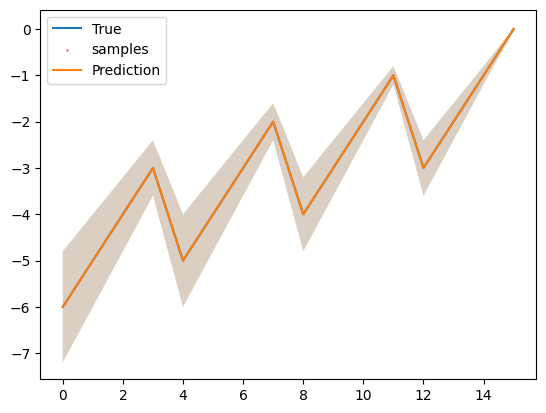

In [7]:
# Plot the true distribution and a batch of 10 samples
import matplotlib.pyplot as plt
plt.plot(x, Y_mean, label='True')
plt.fill_between(x, Y_mean - Y_std, Y_mean + Y_std, alpha=0.2)
# X_batch, Y_batch = generate_batch(10)
plt.scatter(X_samples, Y_samples, 0.2, c='r', label='samples')
plt.plot(x_test, pred_y_mean, label='Prediction')
plt.fill_between(x_test, pred_y_mean - np.sqrt(pred_y_var), pred_y_mean + np.sqrt(pred_y_var), alpha=0.2)
plt.legend()

In [8]:
print(np.sqrt(pred_y_var))
print(Y_std)

[1.1983706  1.0012071  0.79891014 0.5971394  0.9982673  0.79698735
 0.5975368  0.39943463 0.7932866  0.59955806 0.39937165 0.19845556
 0.59872335 0.39882615 0.19920073 0.05415645]
[1.2 1.  0.8 0.6 1.  0.8 0.6 0.4 0.8 0.6 0.4 0.2 0.6 0.4 0.2 0. ]
